# 3D Quality Score Plot with reference from the following images

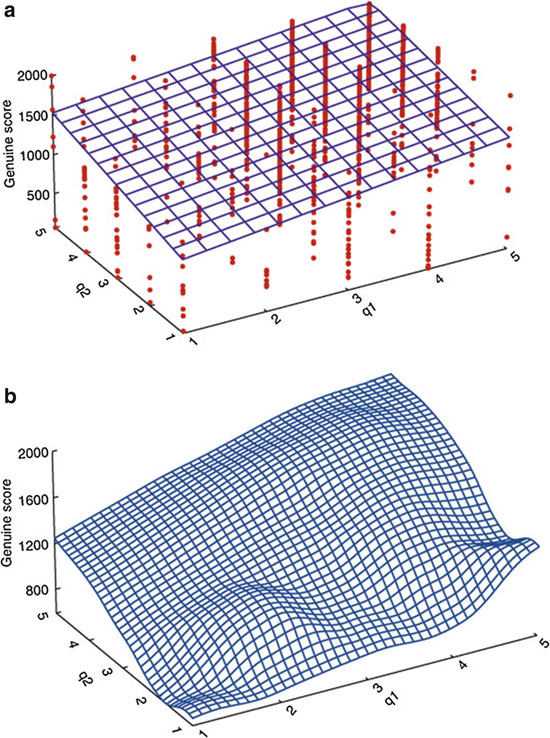


With reference to the image above, we can set q1 to be the reference image quality score, q2 to be the probe image quality score and finally the Z axis to be the matching scores.

### Step 1: Establish a connection to the database

In [ ]:
import gc # This is required for the ram fix
import pandas as pd # This is for the dataframe
import os # This is for the operating system functionalities like reading the file directory, etc.
import psutil
import numpy as np
import time # This is just a rough gauge for us to estimate how much time we require to process each file
from tkinter import Tk # This is to provide a user interface for the user to select the file/folder for the quality and matching scores
from tkinter.filedialog import askdirectory
from tkinter import filedialog as fd
import matplotlib.pyplot as plt # This is for the plotting of the graph
from sqlalchemy import create_engine # This is for us to interface with the SQL for the issuing of commands and retrieving information once that is done

def database_connection():
    DB_USER = 'root'
    try:
        with open(r'C:\Users\B&P\Documents\analytics_platform\DB_Password.txt', 'r') as file:
            DB_PASSWORD = file.read().strip()  # Strip any extra spaces/newlines
    except FileNotFoundError:
        raise Exception("DB_Password.txt file not found. Please make sure the password file is in the correct location.")
    DB_HOST = '127.0.0.1'
    DB_PORT = '3306'
    DB_NAME = 'iNspectorate_implementation'
    global engine
    connection_string = f'mariadb://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    engine = create_engine(connection_string)
database_connection()
print("Connection to the DB has been established!")


### Step 2: Extraction of the information from the database

In [ ]:
# For the first query, we will be obtaining the information from compiled matching scores, we will need to map 
query = "SELECT ID1, ID2, `Matching Score` FROM compiled_matching_scores"

df_compiled = pd.read_sql(query, con=engine) # This is for you to insert the data from the SQL into a dataframe in pandas

# This set of codes is to check for mated and non mated pairs

df_compiled['Same_IDs'] = df_compiled['ID1'] == df_compiled['ID2']
df_compiled['Same_IDs'] = df_compiled['Same_IDs'].map({True: 'Y', False: 'N'})
#making 2 dataframes, basically here we are just copying the data that is mated and non-mated into the dataframe
df_true = df_compiled[df_compiled['Same_IDs'] == 'Y'].copy()
df_false = df_compiled[df_compiled['Same_IDs'] == 'N'].copy()
df_true.drop(df_true.tail(1).index,inplace=True)
# This is just to visualise that what we are doing is correct
# print(df_true)
# print(df_false)

# From here we need to drop the column called Same_IDs to remove the mated and non-mated labelling
df_true.drop(columns=['Same_IDs'], inplace=True)
df_false.drop(columns=['Same_IDs'], inplace=True)

print("Dropping the Same_IDs column")
print(df_true)
print(df_false)

In [ ]:
# From here we need to load in the data for the compiled quality score

query = "SELECT ID, `Quality Score E`, `Quality Score L` FROM compiled_quality_scores"
df_EL = [] # We are just going to reuse this portion of the script
df_EL = pd.read_sql(query, con=engine)
print("DF for Enrolled and Live")
print(df_EL)

# Merge df_true with df_EL to get Quality Score E for ID1 and Quality Score L for ID2

df_mated = df_true.merge(df_EL[['ID', 'Quality Score L']], left_on='ID1', right_on='ID', how='left') \
                  .merge(df_EL[['ID', 'Quality Score E']], left_on='ID2', right_on='ID', how='left') \
                  .drop(columns=['ID_x', 'ID_y'])
'''
# Before we use df_true, we need to drop the duplicated column
df_true.drop(columns=["ID2"], axis=1, inplace=True)
print("DF for mated, dropped ID2")
print(df_true)

df_mated = df_EL.merge(df_true[['ID1', 'Matching Score']], left_on='ID', right_on='ID1', how='left')
#df_mated = df_true.merge(df_EL[['ID', 'Quality Score L']], left_on='ID1', right_on='ID', how='left')

#df_mated = df_true.merge(df_EL[['ID', 'Quality Score E']], left_on='ID2', right_on='ID', how='left') 
'''
# Rename columns for clarity
df_mated.rename(columns={
    'Quality Score L': 'Quality Score L (ID1)',
    'Quality Score E': 'Quality Score E (ID2)'
}, inplace=True)
df_mated = df_mated[['Quality Score L (ID1)', 'Quality Score E (ID2)', 'Matching Score']]
'''


# In the event for duplicates and you want to check
duplicates = df_mated[df_mated.duplicated(subset='ID', keep=False)]
print(duplicates)
'''
# Drop original ID1 and ID2 columns, keeping only quality scores and matching score
# df_mated = df_mated[['Quality Score L (ID1)', 'Quality Score E (ID2)', 'Matching Score']]
print(df_mated)


In [ ]:
df_mated

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Prepare the data
x = df_mated['Quality Score E (ID1)']   # X-axis
y = df_mated['Quality Score L (ID2)']   # Y-axis
z = df_mated['Matching Score']          # Z-axis

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o', s=20)  # Color by matching score

# Label the axes
ax.set_xlabel('Quality Score E (ID1)')
ax.set_ylabel('Quality Score L (ID2)')
ax.set_zlabel('Matching Score')

# Add color bar to indicate matching score scale
cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_label('Matching Score')

# Set the title
ax.set_title('3D Plot: Quality Scores vs Matching Score')

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create bins for Quality Score E, Quality Score L, and Matching Score
bins_E = np.linspace(df_mated['Quality Score L (ID1)'].min(), df_mated['Quality Score L (ID1)'].max(), 20)
bins_L = np.linspace(df_mated['Quality Score E (ID2)'].min(), df_mated['Quality Score E (ID2)'].max(), 20)

# 2D histogram to count frequency
hist, xedges, yedges = np.histogram2d(
    df_mated['Quality Score L (ID1)'], 
    df_mated['Quality Score E (ID2)'], 
    bins=[bins_E, bins_L]
)

# Prepare the grid for plotting
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)  # Base of bars at 0

# Flatten the histogram for bar heights
dz = hist.ravel()

# Bar dimensions
dx = dy = (xedges[1] - xedges[0]) * 0.9  # Adjust bar width/length

# Create 3D bar plot
fig = plt.figure(figsize=(12, 15))
ax = fig.add_subplot(111, projection='3d')

# Plotting the bars
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color='skyblue')

# Axis labels
ax.set_xlabel('Quality Score L (ID1)')
ax.set_ylabel('Quality Score E (ID2)')
ax.set_zlabel('Frequency of Matching Scores')

# Title
ax.set_title('3D Frequency Plot of Matching Scores')

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create bins for Quality Score E and Quality Score L
bins_E = np.linspace(df_mated['Quality Score L (ID1)'].min(), df_mated['Quality Score L (ID1)'].max(), 50)
bins_L = np.linspace(df_mated['Quality Score E (ID2)'].min(), df_mated['Quality Score E (ID2)'].max(), 50)

# Create a 2D histogram (frequency counts)
heatmap_data, xedges, yedges = np.histogram2d(
    df_mated['Quality Score L (ID1)'],
    df_mated['Quality Score E (ID2)'],
    bins=[bins_E, bins_L]
)

# Plotting the heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data.T,  # Transpose to align correctly
    cmap='viridis',  # Color map (can be changed to 'coolwarm', 'plasma', etc.)
    xticklabels=np.round(xedges, 2),  # Show Quality Score E labels
    yticklabels=np.round(yedges, 2),  # Show Quality Score L labels
    cbar_kws={'label': 'Frequency'}   # Color bar label
)

# Axis labels and title
plt.xlabel('Quality Score L (ID1)')
plt.ylabel('Quality Score E (ID2)')
plt.title('2D Heatmap of Quality Scores Frequency')

# Adjust tick visibility for clarity
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.gca().invert_yaxis()
# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create bins for Quality Score E (ID1) and Quality Score E (ID2)
bins_E = np.linspace(df_mated['Quality Score L (ID1)'].min(), df_mated['Quality Score L (ID1)'].max(), 30)
bins_L = np.linspace(df_mated['Quality Score E (ID2)'].min(), df_mated['Quality Score E (ID2)'].max(), 30)

# Create a 2D histogram
heatmap_data, xedges, yedges = np.histogram2d(
    df_mated['Quality Score L (ID1)'],
    df_mated['Quality Score E (ID2)'],
    bins=[bins_E, bins_L]
)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    heatmap_data.T,               # Transpose for correct orientation
    cmap='viridis',               # Color map
    cbar_kws={'label': 'Frequency'}  # Color bar label
)

# Invert the Y-axis to make it ascending
plt.gca().invert_yaxis()

# Adjust X-axis ticks
x_tick_positions = np.linspace(0, len(xedges)-2, 8, dtype=int)   # Adjust tick frequency
x_tick_labels = [f'{xedges[i]:.2f}' for i in x_tick_positions]    # Format labels
plt.xticks(ticks=x_tick_positions, labels=x_tick_labels, rotation=45)

# Adjust Y-axis ticks
y_tick_positions = np.linspace(0, len(yedges)-2, 8, dtype=int)    # Fewer ticks for clarity
y_tick_labels = [f'{yedges[i]:.2f}' for i in y_tick_positions]    # Format labels
plt.yticks(ticks=y_tick_positions, labels=y_tick_labels, rotation=0)

# Axis labels and title
plt.xlabel('Quality Score L (ID1)')
plt.ylabel('Quality Score E (ID2) (Ascending)')
plt.title('2D Heatmap of Quality Scores Frequency')

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

## Finding a method to normalise the quality score and plotting the corresponding matching score

In [ ]:
# Using the df_mated that was prepared earlier

df_true_minimum = df_true.copy()

# inserting another column to do the comparison

df_true_minimum.insert(2, 'Min. Quality', 0)

df_true_minimum

# From here we need to take out the minimum values for the first and second column and placnig them into the Min quality column.

df_true_minimum['Min. Quality'] = df_true_minimum[['Quality Score L (ID1)','Quality Score E (ID2)']].min(axis=1)

#df_mated_minimum

# Then we will be dropping the first 2 columns since they are not needed anymore, then we plot a scatter for Min quality and a line graph for Matching Score

# Remember to define the axis and the inplace
df_true_minimum.drop(columns=["Quality Score L (ID1)","Quality Score E (ID2)"], axis=1, inplace=True)

df_true_minimum

In [ ]:
# We will be plotting

import matplotlib.pyplot as plt

# Assuming your dataframe is called df
plt.scatter(df_true_minimum.iloc[:, 0], df_true_minimum.iloc[:, 1])

# Adding labels (optional)
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.title('Scatter Plot of First and Second Columns')

plt.show()


